In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-pc56rkue
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-pc56rkue
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=d37630444a3bbfc22adb287126375feaa6d60540397bb355fe224aaf7de1c696
  Stored in directory: /tmp/pip-ephem-wheel-cache-zemgt51c/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2


In [2]:
import xarray as xr

In [3]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 661.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb

# Hitting statistics and Wins Above Replacement

My project uses a dataset borrowed from Ben Gaskins. I want to find if a player's slugging percentage, on base percentage and runs batted in contributes to their wins above replacements for MLB players. I am a big fan of the MLB and, like most fans, I believe that the best hitters are also the best players. This project will test that theory.

In [50]:
baseball = pd.read_csv('https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv', header=0)
baseball


,k,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos
0,1.0,Jarren Duran*,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,...,129.0,0.373,134.0,330.0,6.0,6.0,1.0,3.0,1.0,OF
1,2.0,Shohei Ohtani*,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,...,190.0,0.449,190.0,411.0,7.0,6.0,0.0,5.0,10.0,DH
2,3.0,Gunnar Henderson*,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,...,159.0,0.385,157.0,333.0,2.0,7.0,0.0,4.0,1.0,SS
3,4.0,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,...,100.0,0.310,100.0,254.0,9.0,3.0,0.0,1.0,2.0,2B
4,5.0,Juan Soto*,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,...,178.0,0.424,179.0,328.0,10.0,4.0,0.0,4.0,2.0,OF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,738.0,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
772,739.0,Kirby Yates*,37.0,TEX,AL,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
773,740.0,Alex Young*,30.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
774,741.0,Guillo Zuñiga,25.0,LAA,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [51]:
baseball = baseball.query('PA>200')
baseball = baseball[['Player', 'SLG', 'RBI', 'OBP', 'WAR']]
baseball

,Player,SLG,RBI,OBP,WAR
0,Jarren Duran*,0.492,75.0,0.342,8.7
1,Shohei Ohtani*,0.646,130.0,0.390,9.2
2,Gunnar Henderson*,0.529,92.0,0.364,9.1
3,Marcus Semien,0.391,74.0,0.308,4.1
4,Juan Soto*,0.569,109.0,0.419,7.9
...,...,...,...,...,...
360,Trent Grisham*,0.385,31.0,0.290,0.4
361,Kyle Stowers*,0.333,24.0,0.268,-0.5
362,Jackson Holliday*,0.311,23.0,0.255,0.1
363,Jorge Mateo,0.401,18.0,0.267,0.9


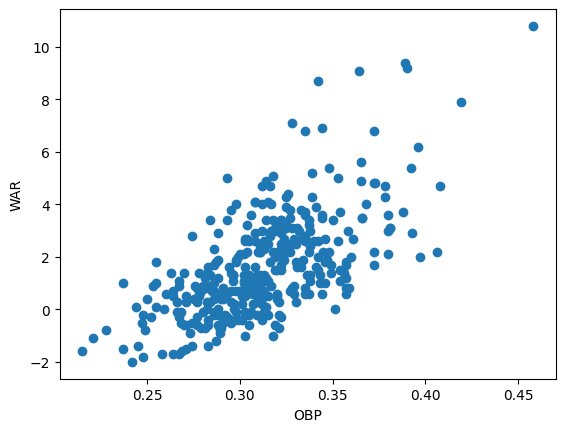

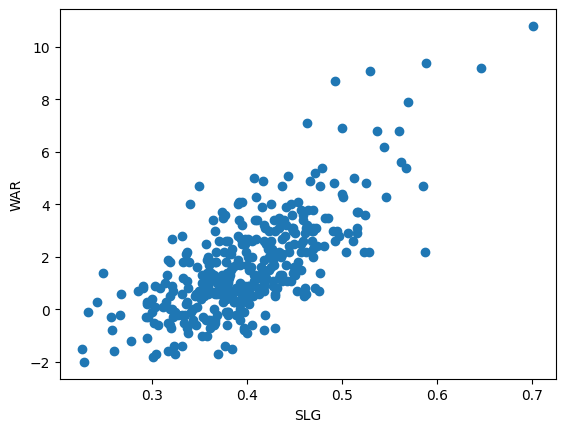

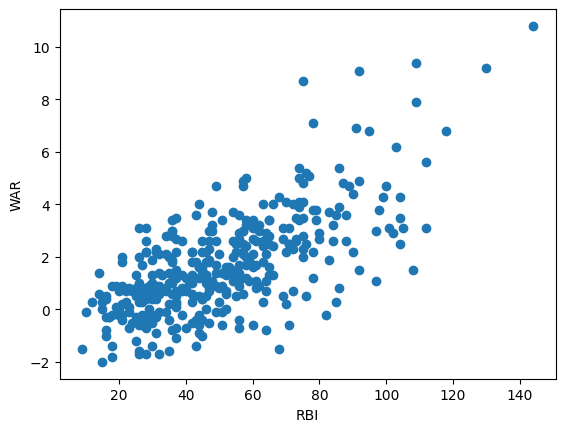

In [52]:
x = ["OBP", "SLG", "RBI",]
y = "WAR"
for a in x:
  plt.scatter(baseball[a], baseball[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

These scatterplots show, for the most part, that as the three tested stats increase, so does WAR. That being said, it looks like SLG and OBP's relationships are tighter than RBI. So I will make models: one will just use OBP and SLAg and the other will use all 3 variables.

In [53]:
model = bmb.Model("WAR ~ OBP + SLG", baseball)
idata = model.fit(idata_kwargs={"log_likelihood":True})

Output()

In [54]:
model_2 = bmb.Model("WAR ~ OBP + SLG + RBI", baseball)
idata_2 = model.fit(idata_kwargs={"log_likelihood":True})

Output()

In [57]:
compare = az.compare({"OBP + SLG": idata, "+ RBI": idata_2})
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
OBP + SLG,0,-615.980413,4.808190,0.000000,1.000000e+00,16.500306,0.000000,False,log
+ RBI,1,-616.037557,4.878505,0.057143,2.220446e-16,16.579555,0.107632,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

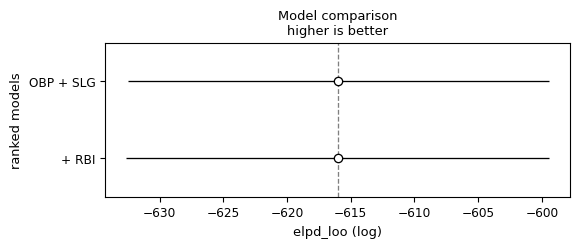

In [58]:
az.plot_compare(compare)

Because the elpd_loo is identical in both models, I will neglect the RBI model to reduce the risk of overfitting.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='OBP', ylabel='WAR'>], dtype=object))

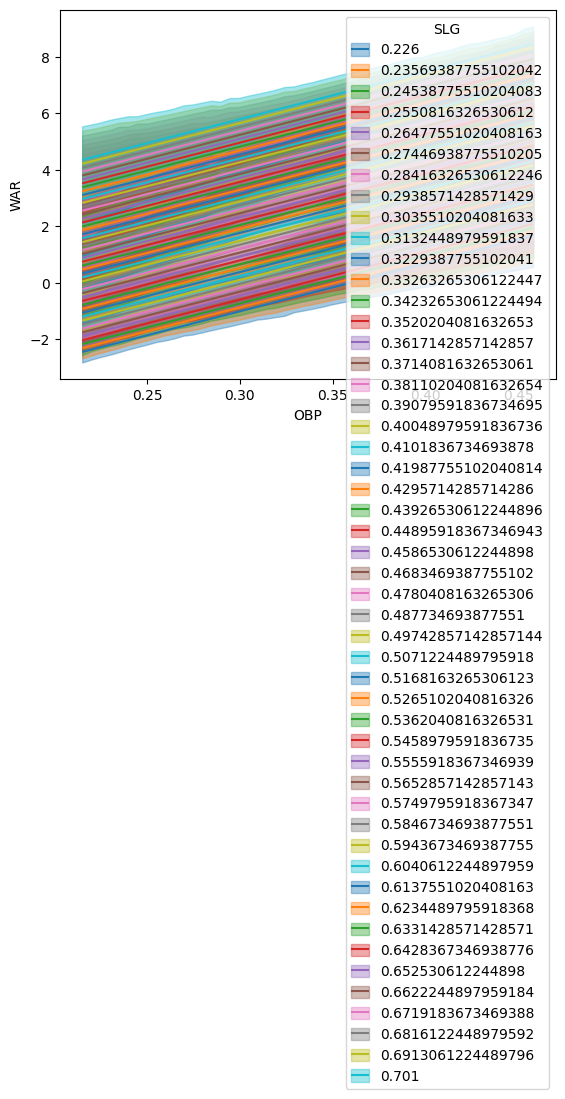

In [59]:
bmb.interpret.plot_predictions(model, idata, ["OBP", "SLG"])

This model proves my hypothesis to be correct as slugging percentage and on base percentage positively correlates to a higher wins above replacement.